# MMM-Oxford 2x2 SARS-CoV-2 truth set

Comparing SARS2-positive samples from a mixture of cultured and high Ct patient samples using combinations of:
1. Nanopore and Illumina sequencing
2. ARTIC v3 amplicon sequencing and SISPA whole genome amplification

---

## Notes


### Locations
- OCI bucket: `SARS-CoV-2_reference_ox`
- MMM `analysis1`: `/home/ndm.local/bede/covid/truth/fastq/`

### Filename construction
- Oxford Nanopore (`platform == 'ont'`)
    - `{name}.fastq.gz` (e.g. `mmm-artic-ont_s10370_1.fastq.gz`)
 
- Illumina (`platform == 'ill'`):
    - `{name}.r1.fastq.gz` (e.g. `mmm-artic-ill_s10370_1.r1.fastq.gz`)
    - `{name}.r2.fastq.gz` (e.g. `mmm-artic-ill_s10370_1.r2.fastq.gz`)

`{fastq_filename}` field includes asterisk for globbing r1 and r2.

### Fields

- `replicate` refers to a given sample-platform-amplification combination
- `sample` is a truncated hash of the original identifying sample name/accession
    - `'s' + str(int(hashlib.sha1(x.encode()).hexdigest(), 16)).str[:6]`


### QC

- `cov20_pc` and `median_depth` calculated from minimap2+samtools depths output using reference `MN908947.3`  
- Pangolin currently called using ARTIC Fieldbioinformatics consensus sequence for ARTIC-Nanopore data only, extrapolated to Illumina and SISPA

### Caveats

- Pangolin assignments currently incomplete; to be rerun using platform-amplfication agnostic pipeline?
- Some samples have poor coverage, usually for SISPA
- Currently fastq only, however Nanopore fast5s are available

In [1]:
import datetime
import pandas as pd

today = datetime.date.today().isoformat()

%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('mmm-2x2-truth.2021-07-06.csv').rename(columns={'sample_hash': 'sample'})

print(f'Length: {df.shape[0]}')
df.head(1)

Length: 309


,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version
0,mmm-artic-ill_s24350_1,mmm-artic-ill,culture,s24350,ill,artic,1,mmm-artic-ill_s24350_1*.fastq.gz,99.771689,8734,P.1,3.1.5


## Lineage distribution

<AxesSubplot:>

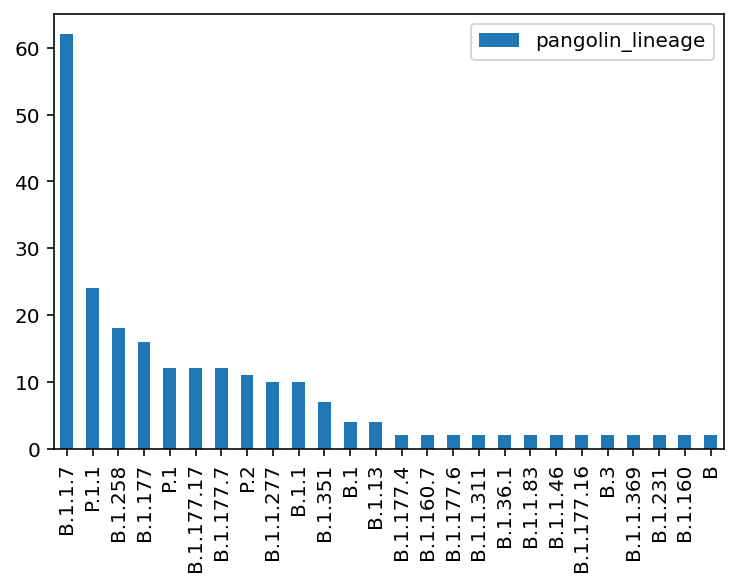

In [3]:
df.pangolin_lineage.value_counts().to_frame().plot.bar()

## Samples for which 2x2 comparison is available

In [4]:
# 2x2 samples exist
twobytwo_df = (df.groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 4"))
print(twobytwo_df.index.nunique())

# 2x2 samples exist and >= 95% cov20
twobytwo_95_df = (df.query("cov20_pc >= 95").groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 4"))
print(twobytwo_95_df.index.nunique())

# ONT + Illumina and >= 95% cov20 
artic_both_platforms_95_df = (df.query("amplification == 'artic' and cov20_pc >= 95").groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['platform']
 .to_frame()
 .query("platform == 2"))
artic_both_platforms_95_df
print(artic_both_platforms_95_df.index.nunique())

23
12
52


## ARTIC v3: lineage calling subset for testing

- **25 ARTIC samples with matched ONT + Illumina**
- Distinct lineages
- Matching ONT+Illumina pairs identified by `matching_pair`
- `cov20_pc > 95`
- `pangolin_lineage` is not `NaN`

In [5]:
lineages_subset_df = (df.query("amplification == 'artic' and cov20_pc >= 95 and pangolin_lineage == pangolin_lineage").groupby(['sample'])
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 2"))

lineages_subset_samples = set(lineages_subset_df.index)

lineages_subset_samples_ont_df = (df.query("sample in @lineages_subset_samples and amplification == 'artic' and cov20_pc > 95 and platform == 'ont'")
                                  .sort_values(['cov20_pc', 'replicate'], ascending=[False, True])
                                  .drop_duplicates(['sample'])
                                  .sort_values('sample')
                                  .drop_duplicates('pangolin_lineage')
                                  .reset_index(drop=True))
lineages_subset_samples_ill_df = (df.query("sample in @lineages_subset_samples and amplification == 'artic' and cov20_pc > 95 and platform == 'ill'")
                                  .sort_values(['cov20_pc', 'replicate'], ascending=[False, True])
                                  .drop_duplicates(['sample'])
                                  .sort_values('sample')
                                  .drop_duplicates('pangolin_lineage')
                                  .reset_index(drop=True))

lineages_subset_samples_ont_df.index.rename('matched_pair', inplace=True)
lineages_subset_samples_ill_df.index.rename('matched_pair', inplace=True)

lineages_subset_samples_ont_df['oci_bucket'] = 'SARS-CoV-2_reference_ox'
lineages_subset_samples_ill_df['oci_bucket'] = 'SARS-CoV-2_reference_ox'

lineages_subset_samples_ont_df.to_csv(f'test-lineage-assignment-ont.{today}.csv')
lineages_subset_samples_ill_df.to_csv(f'test-lineage-assignment-ill.{today}.csv')

lineages_subset_samples_ont_df[['oci_bucket', 'name']].to_csv(f'sp3-test-lineage-assignment-ont.{today}.csv', header=False, index=False)
lineages_subset_samples_ill_df[['oci_bucket', 'name']].to_csv(f'sp3-test-lineage-assignment-ill.{today}.csv', header=False, index=False)

print(lineages_subset_samples_ont_df.shape[0], lineages_subset_samples_ill_df.shape[0])

25 25


In [6]:
lineages_subset_samples_ont_df.head(1)

,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version,oci_bucket
matched_pair,,,,,,,,,,,,,
0,mmm-artic-ont_s10370_1,mmm-artic-ont,clinical,s10370,ont,artic,1,mmm-artic-ont_s10370_1*.fastq.gz,100.0,1509,B.1.1,3.1.5,SARS-CoV-2_reference_ox


In [7]:
lineages_subset_samples_ill_df.head(1)

,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version,oci_bucket
matched_pair,,,,,,,,,,,,,
0,mmm-artic-ill_s10370_1,mmm-artic-ill,clinical,s10370,ill,artic,1,mmm-artic-ill_s10370_1*.fastq.gz,95.507655,648,B.1.1,3.1.5,SARS-CoV-2_reference_ox


## ARTIC v3: lineage calling subset for testing

- **10 samples x 2 replicates (ONT)**
- **11 samples x 2 replicates (Illumina)**
- Distinct lineages
- Matched within-platform pairs denoted by `matching_pair` field
- `cov20_pc > 95`
- `pangolin_lineage` is not `NaN`

In [8]:
repro_subset_ont_df = (df.query("amplification == 'artic' and cov20_pc > 95 and platform == 'ont' and pangolin_lineage == pangolin_lineage").groupby(['sample'])
                   .nunique()['replicate']
                   .to_frame()
                   .query("replicate >= 2")
                   .join(df.set_index('sample')['pangolin_lineage']).drop_duplicates('pangolin_lineage'))
repro_subset_samples_ont = set(repro_subset_ont_df.index)
repro_subset_samples_ont_df = df.query("sample in @repro_subset_samples_ont and amplification == 'artic' and cov20_pc > 95 and platform == 'ont'").sort_values(['cov20_pc', 'replicate'], ascending=[False, True]).groupby('sample').head(2).sort_values(['sample', 'replicate'])

repro_subset_ill_df = (df.query("amplification == 'artic' and cov20_pc > 95 and platform == 'ill' and pangolin_lineage == pangolin_lineage").groupby(['sample'])
                   .nunique()['replicate']
                   .to_frame()
                   .query("replicate >= 2")
                   .join(df.set_index('sample')['pangolin_lineage']).drop_duplicates('pangolin_lineage'))
repro_subset_samples_ill = set(repro_subset_ill_df.index)
repro_subset_samples_ill_df = df.query("sample in @repro_subset_samples_ill and amplification == 'artic' and cov20_pc > 95 and platform == 'ill'").sort_values(['cov20_pc', 'replicate'], ascending=[False, True]).groupby('sample').head(2).sort_values(['sample', 'replicate'])

repro_subset_samples_ont_df['oci_bucket'] = 'SARS-CoV-2_reference_ox'
repro_subset_samples_ill_df['oci_bucket'] = 'SARS-CoV-2_reference_ox'

repro_subset_samples_ont_df['matched_pair'] = repro_subset_samples_ont_df.groupby('sample').ngroup()
repro_subset_samples_ill_df['matched_pair'] = repro_subset_samples_ill_df.groupby('sample').ngroup()

repro_subset_samples_ont_df.to_csv(f'test-repro-assignment-ont.{today}.csv', index=False)
repro_subset_samples_ill_df.to_csv(f'test-repro-assignment-ill.{today}.csv', index=False)

repro_subset_samples_ont_df[['oci_bucket', 'name']].to_csv(f'sp3-test-repro-assignment-ont.{today}.csv', header=False, index=False)
repro_subset_samples_ill_df[['oci_bucket', 'name']].to_csv(f'sp3-test-repro-assignment-ill.{today}.csv', header=False, index=False)

print(repro_subset_samples_ont_df.shape[0], repro_subset_samples_ill_df.shape[0])

20 22


In [9]:
repro_subset_samples_ont_df.head(1)

,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version,oci_bucket,matched_pair
253,mmm-artic-ont_s11511_1,mmm-artic-ont,clinical,s11511,ont,artic,1,mmm-artic-ont_s11511_1*.fastq.gz,100.0,2106,B.1.177,3.1.5,SARS-CoV-2_reference_ox,0


In [10]:
repro_subset_samples_ill_df.head(1)

,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version,oci_bucket,matched_pair
251,mmm-artic-ill_s11511_1,mmm-artic-ill,clinical,s11511,ill,artic,1,mmm-artic-ill_s11511_1*.fastq.gz,100.0,5313,B.1.177,3.1.5,SARS-CoV-2_reference_ox,0


## Everything

In [11]:
pd.set_option('display.max_rows', 500)
df

,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,pangolin_lineage,pangolin_version
0,mmm-artic-ill_s24350_1,mmm-artic-ill,culture,s24350,ill,artic,1,mmm-artic-ill_s24350_1*.fastq.gz,99.771689,8734,P.1,3.1.5
1,mmm-artic-ill_s24350_2,mmm-artic-ill,culture,s24350,ill,artic,2,mmm-artic-ill_s24350_2*.fastq.gz,99.969782,2474,P.1,3.1.5
2,mmm-artic-ill_s24350_3,mmm-artic-ill,culture,s24350,ill,artic,3,mmm-artic-ill_s24350_3*.fastq.gz,99.969782,7507,P.1,3.1.5
3,mmm-artic-ont_s24350_1,mmm-artic-ont,culture,s24350,ont,artic,1,mmm-artic-ont_s24350_1*.fastq.gz,100.000000,961,P.1,3.1.5
4,mmm-artic-ont_s24350_2,mmm-artic-ont,culture,s24350,ont,artic,2,mmm-artic-ont_s24350_2*.fastq.gz,100.000000,2956,P.1,3.1.5
5,mmm-artic-ont_s24350_3,mmm-artic-ont,culture,s24350,ont,artic,3,mmm-artic-ont_s24350_3*.fastq.gz,100.000000,4068,P.1,3.1.5
6,mmm-sispa-ill_s24350_1,mmm-sispa-ill,culture,s24350,ill,sispa,1,mmm-sispa-ill_s24350_1*.fastq.gz,100.000000,11651,P.1,3.1.5
7,mmm-sispa-ill_s24350_2,mmm-sispa-ill,culture,s24350,ill,sispa,2,mmm-sispa-ill_s24350_2*.fastq.gz,100.000000,9957,P.1,3.1.5
8,mmm-sispa-ill_s24350_3,mmm-sispa-ill,culture,s24350,ill,sispa,3,mmm-sispa-ill_s24350_3*.fastq.gz,99.996642,7626,P.1,3.1.5
9,mmm-sispa-ont_s24350_1,mmm-sispa-ont,culture,s24350,ont,sispa,1,mmm-sispa-ont_s24350_1*.fastq.gz,100.000000,647,P.1,3.1.5
